In [19]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
df = pd.read_csv('raw_result.csv')

In [21]:
cont_df = df[(df['model'].isin([
    'bloomz-560m',
    'xss-bloomz-560m', 
    'xss-bloomz-560m-R-1000',
    'xss-bloomz-560m-R-10000',
    'xss-bloomz-560m-R-100000',
    'pair-bloomz-560m', 
    'pair-bloomz-560m-R-1000',
    'pair-bloomz-560m-R-10000',
    'pair-bloomz-560m-R-100000',
    'bilingual-bloomz-560m',
    'bilingual-bloomz-560m-R-1000',
    'bilingual-bloomz-560m-R-10000',
    'bilingual-bloomz-560m-R-100000'
])) & (df['task_lang_group'] != 'unseen')]

In [22]:
tl_df = cont_df[
    (cont_df['prompt_lang'] == 'EN') 
    & (cont_df['task'].isin(['nusax_senti', 'nusa_kalimat_senti']))
].groupby(['model', 'task_lang_group'])['weighted_f1'].agg(['mean']).reset_index()

mdl_df = cont_df[
    (cont_df['prompt_lang'] == 'EN') 
    & (cont_df['task'].isin(['nusax_senti', 'nusa_kalimat_senti']))
].groupby(['model'])['weighted_f1'].agg(['mean']).reset_index()

In [24]:
tl_df['objective'] = tl_df['model'].apply(lambda x: 'baseline' if x.split('-')[0] == 'bloomz' else x.split('-')[0])
tl_df['rehearse'] = tl_df['model'].apply(lambda x: 0 if x.split('-')[-1] == '560m' else int(x.split('-')[-1]))

mdl_df['objective'] = mdl_df['model'].apply(lambda x: 'baseline' if x.split('-')[0] == 'bloomz' else x.split('-')[0])
mdl_df['rehearse'] = mdl_df['model'].apply(lambda x: 0 if x.split('-')[-1] == '560m' else int(x.split('-')[-1]))
mdl_df['task_lang_group'] = 'avg'

In [25]:
baseline_df = tl_df[tl_df['objective'] == 'baseline'].copy()
xss_df = tl_df[tl_df['objective'] == 'xss'].copy()
tlm_df = tl_df[tl_df['objective'] == 'bilingual'].copy()
pair_df = tl_df[tl_df['objective'] == 'pair'].copy()

In [26]:
avg_baseline_df = mdl_df[mdl_df['objective'] == 'baseline'].copy()
avg_xss_df = mdl_df[mdl_df['objective'] == 'xss'].copy()
avg_tlm_df = mdl_df[mdl_df['objective'] == 'bilingual'].copy()
avg_pair_df = mdl_df[mdl_df['objective'] == 'pair'].copy()

In [27]:
baseline_scores = baseline_df[('mean')].values
baseline_scores = np.concatenate([baseline_scores, baseline_scores, baseline_scores, baseline_scores])

In [28]:
xss_df['mean'] -= baseline_scores
tlm_df['mean'] -= baseline_scores
pair_df['mean'] -= baseline_scores

In [29]:
avg_baseline_scores = avg_baseline_df[('mean')].values
avg_baseline_scores = np.concatenate([avg_baseline_scores, avg_baseline_scores, avg_baseline_scores, avg_baseline_scores])

In [30]:
avg_xss_df['mean'] -= avg_baseline_scores
avg_tlm_df['mean'] -= avg_baseline_scores
avg_pair_df['mean'] -= avg_baseline_scores

In [31]:
xss_df = pd.concat([avg_xss_df, xss_df])
tlm_df = pd.concat([avg_tlm_df, tlm_df])
pair_df = pd.concat([avg_pair_df, pair_df])

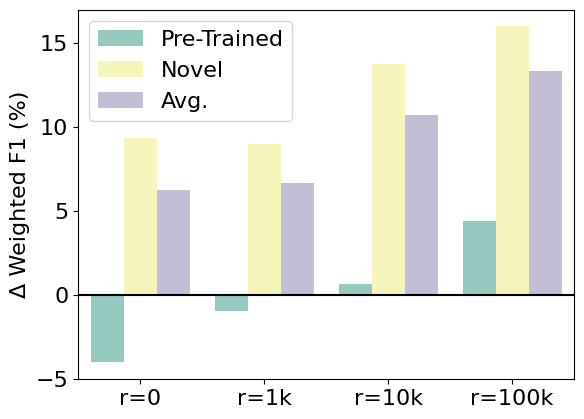

In [36]:
p_xss_df = xss_df.copy()
p_xss_df['mean'] *= 100
task_lang_map = {'pretrained': 'Pre-Trained', 'novel': 'Novel', 'avg': 'Avg.'}
p_xss_df['task_lang_group'] = p_xss_df['task_lang_group'].apply(lambda x: task_lang_map[x])
p_xss_df = p_xss_df.rename({'task_lang_group': 'Language Group'}, axis='columns')

ax = sns.barplot(
    p_xss_df.sort_values('Language Group', ascending=False), x='rehearse', y='mean', 
    hue='Language Group', palette='Set3'
)
ax.axhline(0,0,1,color='black')
plt.xticks([0, 1, 2, 3], ['r=0', 'r=1k', 'r=10k', 'r=100k'], rotation=0, fontsize=16)
plt.xlabel('')
plt.yticks([-5, 0, 5, 10, 15],fontsize=16)
plt.ylabel('Δ Weighted F1 (%)', fontsize=16)
plt.legend(fontsize=16)
plt.savefig('xss_r.png', bbox_inches='tight')

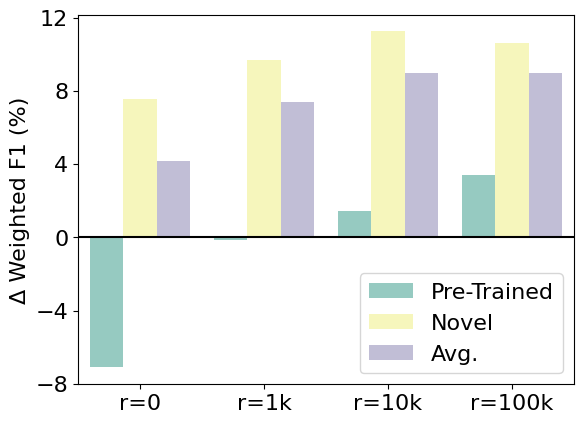

In [37]:
p_tlm_df = tlm_df.copy()
p_tlm_df['mean'] *= 100
task_lang_map = {'pretrained': 'Pre-Trained', 'novel': 'Novel', 'avg': 'Avg.'}
p_tlm_df['task_lang_group'] = p_tlm_df['task_lang_group'].apply(lambda x: task_lang_map[x])
p_tlm_df = p_tlm_df.rename({'task_lang_group': 'Language Group'}, axis='columns')
ax = sns.barplot(
    p_tlm_df.sort_values('Language Group', ascending=False), x='rehearse', y='mean', 
    hue='Language Group', palette='Set3'
)
ax.axhline(0,0,1,color='black')
plt.xticks([0, 1, 2, 3], ['r=0', 'r=1k', 'r=10k', 'r=100k'], rotation=0, fontsize=16)
plt.xlabel('')
plt.yticks([-8, -4, 0, 4, 8, 12], fontsize=16)
plt.ylabel('Δ Weighted F1 (%)', fontsize=16)
plt.legend(fontsize=16)
plt.savefig('tlm_r.png', bbox_inches='tight')

## p_pair_df = pair_df.copy()
p_pair_df['mean'] *= 100
ax = sns.barplot(
    p_pair_df.sort_values('task_lang_group', ascending=False), x='rehearse', y='mean', 
    hue='task_lang_group', palette='Set2'
)
ax.axhline(0,0,1,color='black')
plt.xticks([0, 1, 2, 3], ['0', '1k', '10k', '100k'], rotation=0, fontsize=16)
plt.xlabel('')
plt.yticks(fontsize=16)
plt.ylabel('Δ Weighted F1 (%)', fontsize=16)

In [49]:
df[
    df['task'].isin(['nusax_senti', 'nusa_kalimat_senti'])
    & df['model'].isin([
        'bloom-560m', 'bloom-1b1', 'bloom-3b',
        'bloomz-560m', 'bloomz-1b1', 'bloomz-3b',
        'xss-bloomz-560m', 
        'xss-bloomz-560m-R-1000',
        'xss-bloomz-560m-R-10000',
        'xss-bloomz-560m-R-100000',
        'xss-bloomz-1b1-R-100000',
        'bilingual-bloomz-560m',
        'bilingual-bloomz-560m-R-1000',
        'bilingual-bloomz-560m-R-10000',
        'bilingual-bloomz-560m-R-100000',
        'bilingual-bloomz-1b1-R-100000'
    ])
].groupby(['task_lang_group', 'model'])['weighted_f1'].mean().reset_index().pivot('model', 'task_lang_group', 'weighted_f1')

task_lang_group,novel,pretrained,unseen
model,,,
bilingual-bloomz-1b1-R-100000,0.590644,0.667328,0.584706
bilingual-bloomz-560m,0.420243,0.492612,0.477621
bilingual-bloomz-560m-R-1000,0.473202,0.610546,0.477847
bilingual-bloomz-560m-R-10000,0.489006,0.626418,0.552529
bilingual-bloomz-560m-R-100000,0.482969,0.646043,0.480726
bloom-1b1,0.306544,0.292393,0.433448
bloom-3b,0.260791,0.297135,0.331625
bloom-560m,0.258427,0.310503,0.313099
bloomz-1b1,0.465393,0.627730,0.487620


# Effect of Model Scaling

In [166]:
df = pd.read_csv('raw_result.csv')

In [176]:
cont_df = df[(df['model'].isin([
    'bloom-560m',
    'bloom-1b1',
    # 'bloom-1b7',
    'bloom-3b',
    'bloomz-560m',
    'bloomz-1b1',
    # 'bloomz-1b7',
    'bloomz-3b',
    'xss-bloomz-560m-R-1000',
    'xss-bloomz-560m-R-10000',
    'xss-bloomz-560m-R-100000',
    'xss-bloomz-1b1-R-100000',
    'bilingual-bloomz-560m-R-1000',
    'bilingual-bloomz-560m-R-10000',
    'bilingual-bloomz-560m-R-100000',
    'bilingual-bloomz-1b1-R-100000'
]))  
& (df['prompt_lang'] == 'EN')
& (df['task_lang_group'] != 'unseen')
& (df['task'].isin(['nusax_senti', 'nusa_kalimat_senti']))]

In [177]:
def get_size(model_name):
    if '560m' in model_name:
        return 560
    elif '1b1' in model_name:
        return 1100
    elif '1b7' in model_name:
        return 1700
    elif '3b' in model_name:
        return 3000
    else:
        return 0
    
order_map = {'bloom': 0, 'bloomz': 1, 'xss': 2, 'bilingual': 3}
    
cont_df['size'] = cont_df['model'].apply(get_size)
cont_df['method'] = cont_df['model'].apply(lambda x: x.split('-')[0])
cont_df['order'] = cont_df['method'].apply(lambda x: order_map[x])

/tmp/ipykernel_10700/1938716078.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cont_df['size'] = cont_df['model'].apply(get_size)
/tmp/ipykernel_10700/1938716078.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cont_df['method'] = cont_df['model'].apply(lambda x: x.split('-')[0])
/tmp/ipykernel_10700/1938716078.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

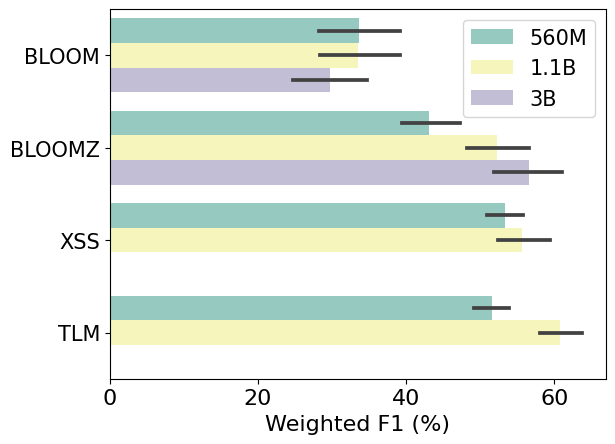

In [193]:
p_cont_df = cont_df.sort_values('order').copy()
p_cont_df['weighted_f1'] = p_cont_df['weighted_f1'] * 100

ax = sns.barplot(p_cont_df, x='method', y='weighted_f1', hue='size', palette='Set3')
handles, _ = ax.get_legend_handles_labels()
plt.legend(title='', handles=handles, labels=['560M', '1.1B', '3B'], fontsize=15)
plt.xticks([0, 1, 2, 3], ['BLOOM', 'BLOOMZ', 'XSS', 'TLM'], fontsize=15)
plt.yticks([0, 20, 40, 60], fontsize=16)
plt.xlabel('')
plt.ylabel('Weighted F1 (%)', fontsize=16)
plt.savefig('model_scale.png', bbox_inches='tight')

In [396]:
sns.color_palette('Set2')

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [397]:
str(sns.color_palette('Set2').as_hex())

"['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f', '#e5c494', '#b3b3b3']"

# Draw relation between novel & unseen

In [195]:
ddf = pd.read_csv('delta_novel_unseen.csv')

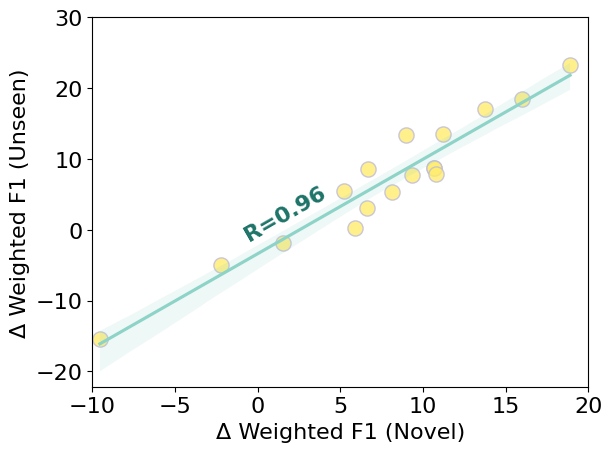

In [335]:
ax = sns.regplot(
    ddf, x='delta_novel', y='delta_unseen', line_kws={"color": "#8dd3c7"},
    scatter_kws={"color": "#ffed6f", "s": 120, "edgecolors":"#bebada"}
)
ax.text(-1, -1.5, "R=0.96", rotation=30, color="#1d7367", fontsize=16, weight="bold")
plt.xticks([-10, -5, 0, 5, 10, 15, 20], fontsize=16)
plt.xlim(-10, 20)
plt.xlabel('Δ Weighted F1 (Novel)', fontsize=16)
plt.yticks([-20, -10, 0, 10, 20, 30], fontsize=16)
plt.ylabel('Δ Weighted F1 (Unseen)', fontsize=16)
plt.savefig('novel_unseen.png', bbox_inches='tight')

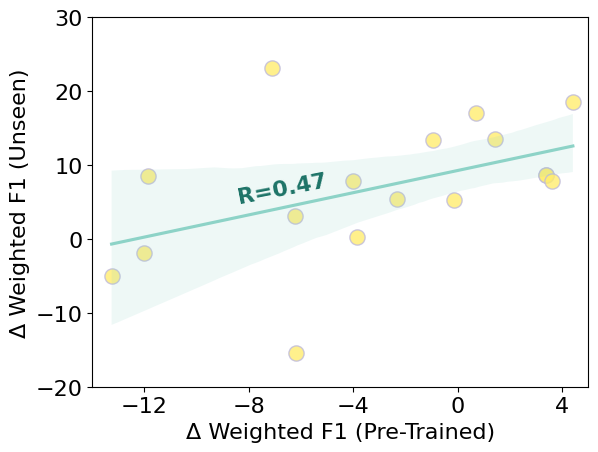

In [336]:
ax = sns.regplot(
    ddf, x='delta_pretrained', y='delta_unseen', line_kws={"color": "#8dd3c7"},
    scatter_kws={"color": "#ffed6f", "s": 120, "edgecolors":"#bebada"}
)
ax.text(-8.5, 4.8, "R=0.47", rotation=11, color="#1d7367", fontsize=16, weight="bold")
plt.xticks([-12, -8, -4, 0, 4], fontsize=16)
plt.xlim(-14,5)
plt.xlabel('Δ Weighted F1 (Pre-Trained)', fontsize=16)
plt.yticks([-20, -10, 0, 10, 20, 30], fontsize=16)
plt.ylabel('Δ Weighted F1 (Unseen)', fontsize=16)
plt.savefig('pretrained_unseen.png', bbox_inches='tight')

In [197]:
ddf

,model,delta_novel,delta_pretrained,delta_unseen
0,monolingual-bloomz-560m,-9.54,-6.21,-15.40
1,translation-bloomz-560m,-2.23,-13.26,-4.99
2,random-bloomz-560m,1.54,-12.00,-1.85
3,bilingual-xss-bloomz-560m,5.88,-3.86,0.29
4,pair-xss-bloomz-560m,6.61,-6.23,3.03
5,xss-bloomz-560m,9.36,-4.01,7.78
6,bilingual-bloomz-560m-R-1000,8.11,-0.16,5.28
7,pair-bloomz-560m,6.65,-11.86,8.51
8,bilingual-bloomz-560m-R-100000,10.64,3.39,8.70
9,bilingual-bloomz-560m-R-100000,10.64,3.39,8.70


# Per Language Performance (NusaX)

In [457]:
df = pd.read_csv('lang_model_perf.csv')


In [458]:
pdf = df[['Language'] + df.columns[2:].tolist()].set_index('Language').loc[[
    'eng', 'ind', 
    'ace', 'ban', 'bjn', 'bug', 'jav', 'min', 'sun',
    'bbc', 'mad', 'nij'
]].T

In [459]:
pdf.index = map(lambda x: x.replace('\\n', '\n'), pdf.index)
pdf = pdf.loc[pdf.index[::2].tolist() + pdf.index[1::2].tolist(),:]

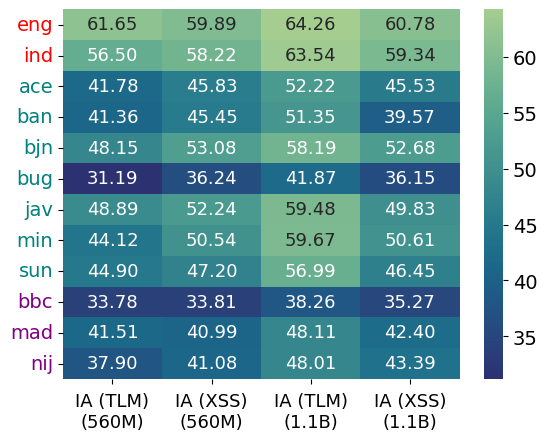

In [481]:
ax = sns.heatmap(pdf.iloc[[1,2,4,5]].T, cmap='crest_r',  annot=True, annot_kws={"size": 13}, fmt=".2f")
ax.tick_params(axis='x', pad=20) 
plt.xticks(rotation=0, va="center", ha="center", fontsize=13)
plt.yticks(rotation=0, fontsize=14)
plt.gca().get_yticklabels()[0].set_color('red')
plt.gca().get_yticklabels()[1].set_color('red')
plt.gca().get_yticklabels()[2].set_color('teal')
plt.gca().get_yticklabels()[3].set_color('teal')
plt.gca().get_yticklabels()[4].set_color('teal')
plt.gca().get_yticklabels()[5].set_color('teal')
plt.gca().get_yticklabels()[6].set_color('teal')
plt.gca().get_yticklabels()[7].set_color('teal')
plt.gca().get_yticklabels()[8].set_color('teal')
plt.gca().get_yticklabels()[9].set_color('purple')
plt.gca().get_yticklabels()[10].set_color('purple')
plt.gca().get_yticklabels()[11].set_color('purple')
plt.xlabel('')
plt.ylabel('')

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)

plt.savefig('per-lang-nusax.png', bbox_inches='tight')